### Reload and subset the genes

Model for the counts in cell n for gene g.
1. Y_ng ~ Poisson(N_n * mu_ng)   # the counts for cell 'n' for gene 'g'. N_n is the total counts in cell n
2. eps_ng ~ Normal(eps_g)  # eps_g is the for gene overdispersion parameter

Assuming that I have few cell-types and that each cell 'n' is assigned to a cell_type 'k'. The poisson rate is a liner function of the covariate X_nl
3. mu_ng = alpha0_kg + sum_l (X_nl * alpha_klg) + eps_ng


The parameters I want to (point-)estimate are:
- alpha0_kg
- alpha_klg
- and to a much lower extent eps_ng

In [1]:
import torch
import numpy 
import matplotlib.pyplot as plt
import seaborn

In [66]:
def generate_fake_data(X_nl, g, k=1, alpha_scale=1E-2, alpha0_loc=-6.0, alpha0_scale=0.5, noise_scale=1E-2):
    n, l = X_nl.shape[:2]
    cell_ids_n = torch.randint(low=0, high=k, size=[n])
    total_umi_n1 = torch.randint(low=250, high=3000, size=[n,1])
    alpha_klg = alpha_scale * torch.randn((k,l,g))
    alpha0_kg = alpha0_loc + alpha0_scale * torch.randn((k,g))
    eps_g = torch.randn(g) * noise_scale  # std per gene
    eps_ng = torch.randn(n,g) * eps_g
    
    log_mu_ng = alpha0_kg[cell_ids_n] + (X_nl[...,None] * alpha_klg[cell_ids_n]).sum(dim=-2) 
    mu_ng = (log_mu_ng + eps_ng).exp()
    rate_ng = total_umi_n1 * mu_ng
    counts_ng = torch.poisson(rate_ng).long()
    
    results = {
        "cell_type_ids_n": cell_ids_n,
        "counts_ng": counts_ng,
        "alpha0_kg": alpha0_kg,
        "alpha_klg": alpha_klg,
        "X_nl": X_nl
    }
    return results


X_nl = torch.randn((20000,10))
fake_data = generate_fake_data(X_nl, g=200, k=9)

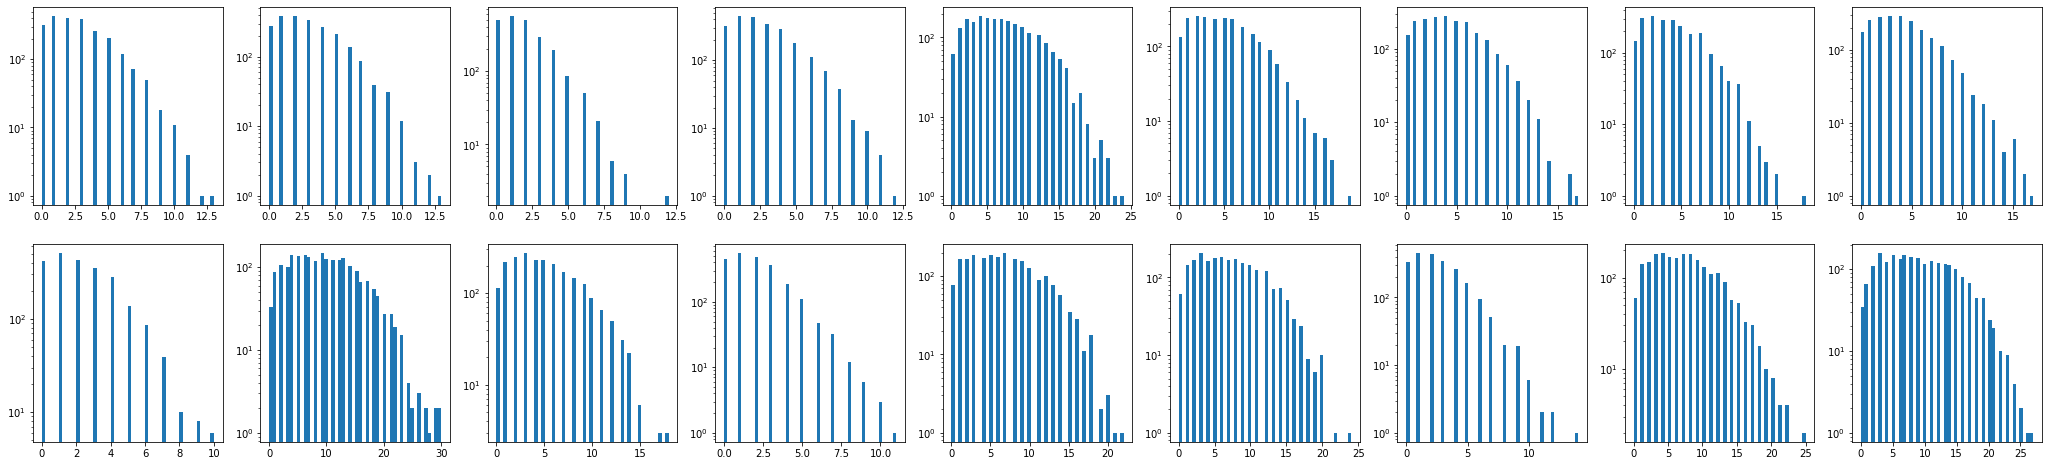

In [67]:
def plot_few_gene_hist(counts_ng, cell_types_n, ncols=4):
    assert counts_ng.shape[0] == cell_types_n.shape[0]
    ctypes = torch.unique(cell_types_n)
    genes = counts_ng.shape[-1]
    
    nrows = genes
    ncols = len(ctypes)
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 4*nrows))

    for r in range(genes):
        tmp = counts_ng[:,r]
        for c, c_type in enumerate(ctypes):
            tmp2 = tmp[cell_types_n == c_type]
            _ = axes[r,c].hist(tmp2, bins=50, density=False, log=True)
    plt.close()
    return fig

counts_ng = fake_data["counts_ng"]
cell_types_n = fake_data["cell_type_ids_n"]
fig = plot_few_gene_hist(counts_ng[:,:2], cell_types_n, ncols=3)
fig

In [68]:
fake_dataset = {
    "cell_type_codes" : fake_data["cell_type_ids_n"],
    "counts": fake_data["counts_ng"], 
    "covariates" : fake_data["X_nl"],
}                               

### Pyro model to fit the counts with a poisson_log_normal model

In [73]:
import pyro
import pyro.poutine as poutine
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDelta
from torch.distributions import constraints


def model_poisson_log_normal(dataset):
    
    counts_ng = dataset['counts'].long()
    covariates_nl = dataset['covariates'].float()  
    cell_type_ids_n = dataset['cell_type_codes'].long()  # ids: 0,1,...,K-1
    k = cell_type_ids_n.max().item()+1
    
    if torch.cuda.is_available(): 
        counts_ng = counts_ng.cuda()
        covariates_nl = covariates_nl.cuda()
        cell_type_ids_n = cell_type_ids_n.cuda()
    device = counts_ng.device
    
    n, g = counts_ng.shape[:2]
    n, l = covariates_nl.shape[:2]
    n = cell_type_ids_n.shape[0]  
    assert isinstance(k, int) and k>0
    assert isinstance(l, int) and l>0
    assert isinstance(n, int) and n>0
    assert isinstance(g, int) and g>0
    
    # Initialize the parameters
    eps_init = 0.001
    alpha0_init = -6.0
    alpha_init = 0.01
    eps_g = pyro.param("eps_g", eps_init * torch.ones(g),
                       constraint=constraints.interval(1E-4, 1E-1)) # shape g
    alpha0_kg = pyro.param("alpha0", alpha0_init * torch.ones((k,g))) # shape k,g
    alpha_klg = pyro.param("alpha", alpha_init * torch.ones((k,l,g))) # shape k,l,g
    
    # print(eps_g.shape, alpha0_kg.shape, alpha_klg.shape)
    
    with pyro.plate("cells", size=n, dim=-2, device=None, subsample_size=n) as ind_n:
        cell_ids_sub_n = cell_type_ids_n[ind_n]
        alpha0_ng = alpha0_kg[cell_ids_sub_n]
        alpha_nlg = alpha_klg[cell_ids_sub_n]
        covariate_sub_nl1 = covariates_nl[cell_ids_sub_n].unsqueeze(dim=-1)
        log_mu_ng = alpha0_ng + torch.sum(covariate_sub_nl1 * alpha_nlg, dim=-2)
        total_umi_n1 = counts_ng[ind_n].sum(dim=-1, keepdim=True) 
    
        with pyro.plate("genes", g, dim=-1, device=None, subsample_size=g) as ind_g:
            eps_ng = pyro.sample("eps_ng", dist.Normal(loc=0, scale=eps_g[ind_g]))
            mu_ng = (log_mu_ng[:,ind_g] + eps_ng).exp()
            rate_ng = mu_ng * total_umi_n1 
            assert torch.all(torch.isfinite(rate_ng))
            pyro.sample("counts", dist.Poisson(rate_ng), obs=counts_ng[ind_n][:,ind_g])
    
guide_poisson_log_normal = AutoDelta(model_poisson_log_normal)


def train(model, guide, dataset, lr=0.005, n_steps=2500, print_frequency=50, clear_param_store=True):
    if clear_param_store:
        pyro.clear_param_store()
    
    adam = pyro.optim.Adam({"lr": lr})
    svi = SVI(model, guide, adam, loss=Trace_ELBO())
    for i in range(n_steps):
        loss = svi.step(dataset)
        if i % print_frequency == 0:
            print('[iter {}]  loss: {:.4f}'.format(i, loss))

In [74]:
trace = poutine.trace(model_poisson_log_normal).get_trace(fake_dataset)
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())

Trace Shapes:                
 Param Sites:                
        eps_g             200
       alpha0           9 200
        alpha     9    10 200
Sample Sites:                
   cells dist               |
        value       20000   |
     log_prob               |
   genes dist               |
        value         200   |
     log_prob               |
  eps_ng dist 20000   200   |
        value 20000   200   |
     log_prob 20000   200   |
  counts dist 20000   200   |
        value 20000   200   |
     log_prob 20000   200   |


In [75]:
# train(model_mle, guide_mle, dataset)
train(model_poisson_log_normal, guide_poisson_log_normal, fake_dataset, 
      n_steps=500, print_frequency=50,
     clear_param_store=True)

#for name, value in pyro.get_param_store().items():
#    print(name, pyro.param(name))

[iter 0]  loss: -9738870.0000
[iter 50]  loss: -15673597.0000


KeyboardInterrupt: 

In [ ]:
#for name, value in pyro.get_param_store().items():
#    print(name, pyro.param(name))

In [76]:
fake_data["alpha0_kg"]

tensor([[-6.3685, -6.5687, -6.1897,  ..., -6.4527, -4.8089, -6.2822],
        [-6.3223, -5.1669, -6.5367,  ..., -6.0705, -5.8935, -5.8306],
        [-6.7435, -5.7823, -6.2361,  ..., -6.4339, -5.5787, -6.0284],
        ...,
        [-5.8788, -6.4437, -7.3363,  ..., -5.8214, -5.8527, -7.1212],
        [-5.9900, -5.4035, -5.8550,  ..., -6.8088, -5.5399, -5.9072],
        [-5.9578, -5.1692, -6.0447,  ..., -6.2425, -6.6826, -7.3549]])

In [77]:
pyro.param("alpha0")

tensor([[-5.9728, -6.0016, -5.9509,  ..., -5.9875, -5.7510, -5.9652],
        [-5.9662, -5.8315, -5.9880,  ..., -5.9347, -5.9159, -5.9089],
        [-6.0237, -5.9289, -5.9724,  ..., -5.9954, -5.9115, -5.9557],
        ...,
        [-5.9194, -5.9801, -6.0793,  ..., -5.9113, -5.9131, -6.0564],
        [-5.9329, -5.8712, -5.9200,  ..., -6.0195, -5.8849, -5.9249],
        [-5.9430, -5.8719, -5.9502,  ..., -5.9692, -6.0056, -6.0657]],
       requires_grad=True)

# PLOT THE REDICTION VS THE REAL